In [1]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


In [2]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=["duration", "like_count", "view_count", "channel_id"],
)
video_metadatas["dummmy"] = 1


In [3]:
# round the subs value, easier to consider 1 sub as a person and not half of a person...
df_time_series.subs = df_time_series.subs.round(0)


# Check length of videos

An idea would be to use cut to match length of videos into discrete intervals 

In [4]:
# long to compute

# bucket_durations = pd.cut(video_metadatas['duration'], bins=100)
# print(type(bucket_durations))


---

# Check frequency of videos

---

# How long to reach 1M subscribers 

Could be interesting to take all the videos with 10K, 20K, 30K, ... and see the evolution to reach 100K for example. And compare different evolution : from 50K to 100K or from 500K to 600K, etc.. which one is the fastest, easiest ?  

In [6]:
under_10K = df_time_series[df_time_series["subs"] < 10_000]
more_1M = df_time_series[df_time_series["subs"] > 1_000_000]


In [7]:
channel_10K_to_1M = df_time_series[
    df_time_series.channel.isin(under_10K.channel)
    & df_time_series.channel.isin(more_1M.channel)
]
print(
    "We have {} channels that begins with 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)


We have 1252 channels that begins with 10K subs and reach at least 1M


There are 113 weeks for this channel
We should have approximately the same value : 
791 and 784 days 00:00:00


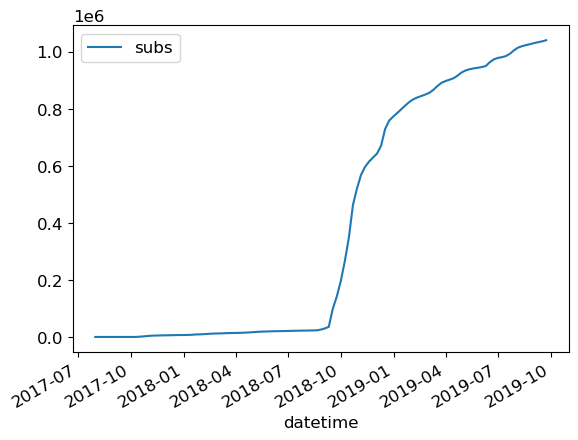

In [8]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)


In [19]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = channel_10K_to_1M.groupby("channel").apply(
    lambda group: pd.Series(
        {
            "from_zero_to_hero_duration": group[group.subs > 1_000_000]["datetime"].iloc[0]
            - group[group.subs < 10_000]["datetime"].iloc[-1]
        }
    )
)
time_to_reach_1M.head()

,from_zero_to_hero_duration
channel,
UC-3fLOkTRb7-tepOqxsDdDg,97 days 23:00:00
UC-5Yj4HIiruwkzFuLflxL_w,574 days 01:00:00
UC-CSyyi47VX1lD9zyeABW3w,769 days 23:00:00
UC-HOjVdbw0TG6h44rH4Sirw,413 days 00:00:00
UC-LUjxkSJCxAMrZ4S0T3Drg,686 days 01:00:00


In [ ]:
print('In average YTbers take {} to reach 1M of subscribers'.format(time_to_reach_1M['from_zero_to_hero_duration'].mean()))

In average YTbers take 511 days 01:01:57.891373800 to reach 1M of subscribers


It would be nice to bootstrap this result to see with interval of confidence the time taken by Youtuber to reach 1M

---

In [23]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [24]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


2010.3396226415093

In [25]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)


59578    2004.0
16       2005.0
40       2005.0
53       2005.0
54       2005.0
Name: join_date, dtype: float64

In [27]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
30,Music,2009-09-02,UC3MLnJtqc_phABBriLRhtgQ,SonyMusicIndiaVEVO,24800000,3013,63.0,2.087
57,Music,2010-12-04,UCbW18JZRgko_mOGm5er8Yzg,OneDirectionVEVO,22900000,171,105.0,2.087
29,Music,2012-09-23,UCa10nxShhzNrCE1o2ZOPztg,Trap Nation,27300000,1779,60.0,2.087
22,Education,2013-02-09,UCBnZ16ahKA2DZ_T5W0FPUXg,ChuChu TV Nursery Rh...,26600000,317,44.0,2.087
41,Gaming,2012-05-26,UC7_YxT-KID8kRbqZo7MyscQ,Markiplier,24400000,4484,86.0,2.087
43,Music,2011-08-14,UC_aEa8K-EOJ3D6gOs7HcyNg,NoCopyrightSounds,23500000,666,88.0,2.087
16,Entertainment,2005-11-06,UCcgqSM4YEo5vVQpqwN-MaNw,Rihanna,32869647,77,33.0,2.087
